In [1]:
import torch
from torch.nn.functional import one_hot
from torch.optim import Adam
import torch.optim as optim

from tqdm import tqdm
from preconditioner import PreconditionerEnv
from policy import ForwardPolicy, BackwardPolicy
from gflownet.gflownet import GFlowNet
from gflownet.utils import sparse_one_hot
from gflownet.utils import trajectory_balance_loss, market_matrix_to_sparse_tensor, log_memory_usage, malloc_usage
import psutil

In [2]:
print(torch.__version__)

1.13.0


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
filename = 'Trefethen_20' 
#filename = 'bcsstk03' #100x100 matrix
#filename = 'olm500' #500x500 matrix

In [5]:
data_directory = 'data/small_ILU/matrices/'

In [6]:
matrix_path = data_directory + filename + '.mtx'  # Update this with your file path
batch_size = 2
num_epochs = 50
lr = 0.00002

In [7]:
import numpy as np
from scipy.io import mmread
from scipy.sparse.linalg import gmres, spilu, LinearOperator
from scipy.sparse import csr_matrix
import time

# Function to load matrix A from .mtx file
def load_mtx_file(file_path):
    matrix = mmread(file_path)
    return csr_matrix(matrix)

def load_vector_mtx(file_path):
    vector = mmread(file_path)  # Load the vector (could be sparse or dense)
    
    # Check if the loaded data is a sparse matrix, if so convert it to a dense array
    if hasattr(vector, "toarray"):
        vector = vector.toarray()
    
    # Flatten the array if it's a row or column vector
    vector = vector.flatten()
    
    return vector

# Function to solve the system using GMRES with an optional preconditioner
def solve_with_gmres(A, b, M=None):
    # Ensure b is a 1D array with the same number of rows as A
    b = b.flatten()
    if b.shape[0] != A.shape[0]:
        raise ValueError(f"Shape mismatch: A is {A.shape}, but b is {b.shape}")
    
    # Initial guess (zero vector)
    x0 = np.zeros(b.shape)

    # Lists to store iteration number and residual norm
    residuals = []
    
    # Callback function to capture residual norm at each iteration
    def callback(rk):
        residuals.append(rk)
    
    # Measure computational time
    start_time = time.time()
    
    # Use GMRES to solve the system Ax = b with preconditioner M
    x, exitCode = gmres(A, b, x0=x0, M=M, maxiter=10260, callback=callback)
    
    elapsed_time = time.time() - start_time
    
    if exitCode == 0:
        print("GMRES converged successfully.")
    else:
        print(f"GMRES did not converge. Exit code: {exitCode}")
    
    # Number of iterations is the length of the residuals list
    num_iterations = len(residuals)
    
    return x, residuals, num_iterations, elapsed_time


In [12]:
# Example usage
mtx_file_path_A = matrix_path  # Replace with your actual matrix file path
mtx_file_path_b = 'data/small_ILU/b_vectors/' + filename + '_b.mtx'

# Load the vector data as a numpy array
b = load_vector_mtx(mtx_file_path_b)



# Load A and b from the .mtx files
A = load_mtx_file(mtx_file_path_A)

In [13]:
log_memory_usage("Before Loading Initial Matrix")

# Load the initial matrix from a file
original_matrix = market_matrix_to_sparse_tensor(matrix_path)

log_memory_usage("After Loading Initial Matrix")


[Before Loading Initial Matrix] CPU Memory Usage: 288.45 MB; VMS: 34750.86 MB
[After Loading Initial Matrix] CPU Memory Usage: 288.45 MB; VMS: 34750.86 MB


In [14]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.sparse.linalg import gmres
import tracemalloc  # For tracking memory usage
#Sparse ILU to create baseline preconditioner

# Compute the ILU factorization
ilu = spla.spilu(A)

# Define a function to apply the ILU preconditioner
M_x = lambda x: ilu.solve(x)

# Create a LinearOperator object from the ILU solver function
M = spla.LinearOperator(A.shape, M_x)

In [17]:
orig_x, orig_residuals, orig_num_iterations, orig_elapsed_time = solve_with_gmres(A, b)
print(orig_num_iterations)
print(orig_elapsed_time)

GMRES converged successfully.
20
0.0019426345825195312


In [16]:
x, residuals, num_iterations, elapsed_time = solve_with_gmres(A, b, M)
print(num_iterations)
print(elapsed_time)

GMRES converged successfully.
2
0.0011069774627685547


In [11]:
#Convert SuperLU object into LU sparse tensor
# Extract L and U from the ILU factorization (spilu)
L = sp.tril(ilu.L, format='csr')  # Lower triangular matrix from ILU
U = sp.triu(ilu.U, format='csr')  # Upper triangular matrix from ILU

# Multiply L and U to form the combined LU matrix
LU = L @ U  # Sparse matrix multiplication to maintain sparsity

# Convert the LU matrix to a PyTorch sparse tensor
coo = LU.tocoo()  # Convert to COO format for PyTorch compatibility
values = coo.data
indices = np.vstack((coo.row, coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = torch.Size(coo.shape)

#Initial matrix to sample for model
initial_matrix = torch.sparse_coo_tensor(i, v, shape)

# Print information about the PyTorch sparse tensor
print(f"PyTorch sparse tensor shape: {initial_matrix.shape}")
print(f"Number of non-zero elements: {initial_matrix._nnz()}")
print(f"Indices: {initial_matrix._indices()}")
print(f"Values: {initial_matrix._values()}")

PyTorch sparse tensor shape: torch.Size([18, 18])
Number of non-zero elements: 90
Indices: tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  3,
          4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10,
         10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14,
         14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17],
        [ 4,  3,  1,  0,  6,  5,  3,  2,  1,  2,  4,  3,  0,  8,  7,  5,  4,  3,
          4,  6,  5,  2,  1, 10,  9,  7,  6,  5,  6,  8,  7,  5,  4,  3, 12, 11,
          9,  8,  7,  8, 10,  9,  7,  6,  5, 14, 13, 11, 10,  9, 10, 12, 11,  8,
          7, 17, 15, 13, 12, 11, 12, 14, 13, 10,  9, 16, 15, 14, 13, 14, 17, 15,
         12, 11, 15, 13,  8,  6,  5,  2,  1,  0, 17, 16, 15, 17, 16, 15, 14, 13]])
Values: tensor([ 4.7715e+02, -8.5888e+04,  1.7178e+05, -4.7715e+02,  4.7715e+02,
        -8.5888

# Structured Sampling Preconditioner

In [12]:
#initial_matrix = structured_sampling(original_matrix, 4, 0.75)
matrix_size = initial_matrix.size(0)

In [13]:
initial_matrix._nnz()

90

In [14]:
# Initialize the environment and policies
env = PreconditionerEnv(matrix_size=matrix_size, initial_matrix=initial_matrix, original_matrix=initial_matrix)
env.data.edge_attr.shape

torch.Size([90])

In [15]:

node_features = -1
input_dim = 1
hidden_dim = 4
max_num_actions = 500
forward_policy = ForwardPolicy(node_features=node_features, hidden_dim=hidden_dim, max_num_actions=max_num_actions)
#forward_policy = ForwardPolicy(node_features=node_features, hidden_dim=hidden_dim, num_actions=env.num_actions)
backward_policy = BackwardPolicy(input_dim=input_dim, hidden_dim=hidden_dim, max_num_actions=max_num_actions)

In [16]:
env.data.edge_attr.shape

torch.Size([90])

In [17]:
initial_matrix.size()

torch.Size([18, 18])

In [18]:
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                print(f"{name}: {param.grad.norm()}")
            else:
                print(f"{name}: No gradient")


In [19]:
log_memory_usage("Before Starting Training")

[Before Starting Training] CPU Memory Usage: 210.46 MB; VMS: 34652.35 MB


In [20]:
import pandas as pd

def capture_training_data(epoch, log, loss, batch_size, report_data=None, detailed_report_data=None):
    """
    Captures and returns the report data and detailed report data from training logs.

    Parameters:
    - epoch (int): The current epoch number.
    - log (object): An object containing training logs with `_actions` and `rewards`.
    - loss (torch.Tensor): The loss value for the current epoch.
    - batch_size (int): The number of samples in the batch.
    - report_data (pd.DataFrame, optional): Existing report DataFrame to be updated. Defaults to None.
    - detailed_report_data (pd.DataFrame, optional): Existing detailed report DataFrame to be updated. Defaults to None.

    Returns:
    - report_data (pd.DataFrame): Updated report DataFrame.
    - detailed_report_data (pd.DataFrame): Updated detailed report DataFrame.
    """
    
    # Initialize DataFrames if not provided
    if report_data is None:
        report_data = pd.DataFrame(columns=['epoch', 'num_actions', 'loss', 'reward'])
    if detailed_report_data is None:
        detailed_report_data = pd.DataFrame(columns=['epoch', 'sample_number', 'num_actions', 'loss', 'reward'])

    # Capture summary data
    total_length = len(log._actions)
    new_report_data = pd.DataFrame([{
        'epoch': epoch,
        'num_actions': total_length,
        'loss': loss.item(),
        'reward': log.rewards
    }])
    report_data = pd.concat([report_data, new_report_data], ignore_index=True)
    
    # Capture detailed data for each sample in the batch
    batch_data = []
    for sample_id in range(batch_size):
        sum_actions = log._actions.t()[sample_id]
        mask_actions = sum_actions != -1
        num_actions = mask_actions.sum()
        reward = log.rewards[sample_id].item() if isinstance(log.rewards, torch.Tensor) else log.rewards[sample_id]
        batch_data.append({
            'epoch': epoch,
            'sample_number': sample_id + 1,  # Sample number within the batch/epoch
            'num_actions': num_actions.item(),
            'loss': loss.item(),
            'reward': reward
        })
    
    detailed_report_data = pd.concat([detailed_report_data, pd.DataFrame(batch_data)], ignore_index=True)

    return report_data, detailed_report_data


In [21]:
import pandas as pd

tracemalloc.start()
# Initialize the GFlowNet model
model = GFlowNet(forward_policy, backward_policy, env)
opt = Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.2, patience=5, verbose=True)


log_memory_usage("After Model Initialization")

report_data = pd.DataFrame(columns=['epoch', 'num_actions', 'loss', 'reward'])

detailed_report_data = pd.DataFrame(columns=['epoch', 'sample_number', 'num_actions', 'loss', 'reward'])

s0 = [initial_matrix.clone() for _ in range(batch_size)]

for epoch in (p := tqdm(range(num_epochs))):
    #malloc_usage(f"Start of Epoch {epoch}")

    model.train()
    #opt.zero_grad()

    # Initialize the starting states
    initial_indices = torch.zeros(batch_size).long()
    #s0 = [sparse_one_hot(initial_indices[i:i+1], env.state_dim).float() for i in range(batch_size)]
    #print(f"Cloned initial matrix")
    #s0 = one_hot(torch.zeros(batch_size).long(), env.state_dim).float()
    # Sample final states and log information
    #malloc_usage("Before Sample States")
    #print(f"Reward Details for Epoch {epoch}")
    log = model.sample_states(s0, return_log=True)
    
    # Calculate the trajectory balance loss
    loss = trajectory_balance_loss(log.total_flow,
                                    log.rewards,
                                    log.fwd_probs,
                                    log.back_probs)
    
    #print(f"log.total_flow {log.total_flow}")
    #print(f"log.rewards {log.rewards}")
    #print(f"log.fwd_probs {len(log.fwd_probs)}")
    #print(f"log.back_probs {len(log.back_probs)}")
    #print(f"log._actions shape {log._actions}")
    #print(f"Loss Calculation: {loss}")
    # Backpropagation and optimization step
    # Check for NaN or Inf in loss before proceeding
    if torch.isnan(loss) or torch.isinf(loss):
        print(f"Warning: NaN or Inf detected in loss at epoch {epoch}. Skipping backpropagation.")
        continue  # Skip the current iteration if NaN or Inf is detected
    scheduler.step(loss)
    loss.backward()
    #check_gradients(model)
    #check_gradients(model)
    opt.step()
    #named_params = model.named_parameters()
    opt.zero_grad()
    #Capture data
    total_length = len(log._actions)
    report_data, detailed_report_data = capture_training_data(epoch=epoch, log=log, loss=loss, batch_size=batch_size, report_data=report_data, detailed_report_data=detailed_report_data)
    
    if epoch % 1 == 0:
       tqdm.write(f"Epoch {epoch} Loss: {loss.item():.3f}, Num_Actions {total_length}")
       log_memory_usage(f"At {epoch} Epochs")



[After Model Initialization] CPU Memory Usage: 243.24 MB; VMS: 34754.44 MB


  2%|▏         | 1/50 [00:22<18:34, 22.75s/it]

Epoch 0 Loss: 453.859, Num_Actions 60
[At 0 Epochs] CPU Memory Usage: 267.75 MB; VMS: 34879.31 MB


  4%|▍         | 2/50 [00:45<18:19, 22.90s/it]

Epoch 1 Loss: 169.442, Num_Actions 61
[At 1 Epochs] CPU Memory Usage: 273.95 MB; VMS: 34886.05 MB


  6%|▌         | 3/50 [01:16<20:37, 26.33s/it]

Epoch 2 Loss: 1639.210, Num_Actions 78
[At 2 Epochs] CPU Memory Usage: 279.45 MB; VMS: 34889.38 MB


  8%|▊         | 4/50 [01:23<14:25, 18.81s/it]

Epoch 3 Loss: 214.490, Num_Actions 18
[At 3 Epochs] CPU Memory Usage: 276.42 MB; VMS: 34885.38 MB


 10%|█         | 5/50 [01:44<14:50, 19.78s/it]

Epoch 4 Loss: 20.144, Num_Actions 55
[At 4 Epochs] CPU Memory Usage: 277.56 MB; VMS: 34884.38 MB


 12%|█▏        | 6/50 [01:59<13:10, 17.96s/it]

Epoch 5 Loss: 13.950, Num_Actions 38
[At 5 Epochs] CPU Memory Usage: 277.66 MB; VMS: 34884.38 MB


 14%|█▍        | 7/50 [02:28<15:34, 21.74s/it]

Epoch 6 Loss: 1364.914, Num_Actions 80
[At 6 Epochs] CPU Memory Usage: 280.43 MB; VMS: 34887.38 MB


 16%|█▌        | 8/50 [02:45<14:07, 20.17s/it]

Epoch 7 Loss: 104.244, Num_Actions 46
[At 7 Epochs] CPU Memory Usage: 280.83 MB; VMS: 34887.38 MB


 18%|█▊        | 9/50 [03:07<14:04, 20.60s/it]

Epoch 8 Loss: 289.149, Num_Actions 59
[At 8 Epochs] CPU Memory Usage: 280.92 MB; VMS: 34887.38 MB


 20%|██        | 10/50 [03:35<15:23, 23.09s/it]

Epoch 9 Loss: 1918.373, Num_Actions 80
[At 9 Epochs] CPU Memory Usage: 281.73 MB; VMS: 34889.38 MB


 22%|██▏       | 11/50 [03:46<12:30, 19.25s/it]

Epoch 10 Loss: 41.104, Num_Actions 30
[At 10 Epochs] CPU Memory Usage: 280.23 MB; VMS: 34886.38 MB


 24%|██▍       | 12/50 [04:11<13:19, 21.04s/it]

Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch 11 Loss: 23.346, Num_Actions 69
[At 11 Epochs] CPU Memory Usage: 281.22 MB; VMS: 34886.38 MB


 26%|██▌       | 13/50 [04:31<12:41, 20.57s/it]

Epoch 12 Loss: 24.602, Num_Actions 53
[At 12 Epochs] CPU Memory Usage: 282.01 MB; VMS: 34888.38 MB


 28%|██▊       | 14/50 [04:38<09:53, 16.50s/it]

Epoch 13 Loss: 128.192, Num_Actions 19
[At 13 Epochs] CPU Memory Usage: 278.25 MB; VMS: 34883.38 MB


 30%|███       | 15/50 [04:59<10:30, 18.00s/it]

Epoch 14 Loss: 315.813, Num_Actions 58
[At 14 Epochs] CPU Memory Usage: 278.48 MB; VMS: 34883.38 MB


 32%|███▏      | 16/50 [05:27<11:50, 20.91s/it]

Epoch 15 Loss: 1159.014, Num_Actions 75
[At 15 Epochs] CPU Memory Usage: 280.02 MB; VMS: 34887.38 MB


 34%|███▍      | 17/50 [05:47<11:25, 20.77s/it]

Epoch 16 Loss: 153.773, Num_Actions 56
[At 16 Epochs] CPU Memory Usage: 280.33 MB; VMS: 34887.38 MB


 36%|███▌      | 18/50 [06:00<09:45, 18.30s/it]

Epoch 00018: reducing learning rate of group 0 to 8.0000e-07.
Epoch 17 Loss: 84.353, Num_Actions 34
[At 17 Epochs] CPU Memory Usage: 278.69 MB; VMS: 34883.38 MB


 38%|███▊      | 19/50 [06:11<08:22, 16.22s/it]

Epoch 18 Loss: 13.962, Num_Actions 31
[At 18 Epochs] CPU Memory Usage: 278.69 MB; VMS: 34883.38 MB


 40%|████      | 20/50 [06:34<09:07, 18.23s/it]

Epoch 19 Loss: 270.361, Num_Actions 61
[At 19 Epochs] CPU Memory Usage: 279.08 MB; VMS: 34884.38 MB


 42%|████▏     | 21/50 [06:37<06:35, 13.65s/it]

Epoch 20 Loss: 127.076, Num_Actions 7
[At 20 Epochs] CPU Memory Usage: 279.08 MB; VMS: 34884.38 MB


 44%|████▍     | 22/50 [06:40<04:51, 10.41s/it]

Epoch 21 Loss: 23.839, Num_Actions 7
[At 21 Epochs] CPU Memory Usage: 279.08 MB; VMS: 34884.38 MB


 46%|████▌     | 23/50 [06:49<04:33, 10.14s/it]

Epoch 22 Loss: 63.238, Num_Actions 25
[At 22 Epochs] CPU Memory Usage: 279.08 MB; VMS: 34884.38 MB


 48%|████▊     | 24/50 [07:05<05:08, 11.88s/it]

Epoch 00024: reducing learning rate of group 0 to 1.6000e-07.
Epoch 23 Loss: 75.911, Num_Actions 43
[At 23 Epochs] CPU Memory Usage: 278.97 MB; VMS: 34883.38 MB


 50%|█████     | 25/50 [07:30<06:32, 15.72s/it]

Epoch 24 Loss: 726.343, Num_Actions 67
[At 24 Epochs] CPU Memory Usage: 280.10 MB; VMS: 34885.38 MB


 52%|█████▏    | 26/50 [07:39<05:25, 13.57s/it]

Epoch 25 Loss: 303.541, Num_Actions 23
[At 25 Epochs] CPU Memory Usage: 280.13 MB; VMS: 34885.38 MB


 54%|█████▍    | 27/50 [08:06<06:46, 17.69s/it]

Epoch 26 Loss: 1371.884, Num_Actions 74
[At 26 Epochs] CPU Memory Usage: 281.30 MB; VMS: 34885.38 MB


 56%|█████▌    | 28/50 [08:16<05:36, 15.28s/it]

Epoch 27 Loss: 79.654, Num_Actions 26
[At 27 Epochs] CPU Memory Usage: 281.30 MB; VMS: 34885.38 MB


 58%|█████▊    | 29/50 [08:31<05:22, 15.36s/it]

Epoch 28 Loss: 17.044, Num_Actions 42
[At 28 Epochs] CPU Memory Usage: 281.32 MB; VMS: 34885.38 MB


 60%|██████    | 30/50 [08:47<05:09, 15.48s/it]

Epoch 00030: reducing learning rate of group 0 to 3.2000e-08.
Epoch 29 Loss: 23.123, Num_Actions 42
[At 29 Epochs] CPU Memory Usage: 281.32 MB; VMS: 34885.38 MB


 62%|██████▏   | 31/50 [09:05<05:09, 16.27s/it]

Epoch 30 Loss: 123.093, Num_Actions 49
[At 30 Epochs] CPU Memory Usage: 281.32 MB; VMS: 34885.38 MB


 64%|██████▍   | 32/50 [09:28<05:31, 18.39s/it]

Epoch 31 Loss: 330.997, Num_Actions 63
[At 31 Epochs] CPU Memory Usage: 281.32 MB; VMS: 34885.38 MB


 66%|██████▌   | 33/50 [09:55<05:57, 21.01s/it]

Epoch 32 Loss: 943.413, Num_Actions 73
[At 32 Epochs] CPU Memory Usage: 283.05 MB; VMS: 34887.38 MB


 68%|██████▊   | 34/50 [10:26<06:20, 23.75s/it]

Epoch 33 Loss: 1957.420, Num_Actions 77
[At 33 Epochs] CPU Memory Usage: 284.58 MB; VMS: 34890.38 MB


 70%|███████   | 35/50 [10:49<05:54, 23.64s/it]

Epoch 34 Loss: 662.362, Num_Actions 63
[At 34 Epochs] CPU Memory Usage: 283.79 MB; VMS: 34887.38 MB


 72%|███████▏  | 36/50 [10:58<04:30, 19.36s/it]

Epoch 00036: reducing learning rate of group 0 to 6.4000e-09.
Epoch 35 Loss: 98.516, Num_Actions 25
[At 35 Epochs] CPU Memory Usage: 283.79 MB; VMS: 34887.38 MB


 74%|███████▍  | 37/50 [11:04<03:19, 15.35s/it]

Epoch 36 Loss: 21.872, Num_Actions 16
[At 36 Epochs] CPU Memory Usage: 282.88 MB; VMS: 34886.38 MB


 76%|███████▌  | 38/50 [11:22<03:11, 15.96s/it]

Epoch 37 Loss: 25.215, Num_Actions 47
[At 37 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 78%|███████▊  | 39/50 [11:33<02:39, 14.52s/it]

Epoch 38 Loss: 42.305, Num_Actions 30
[At 38 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 80%|████████  | 40/50 [11:47<02:23, 14.36s/it]

Epoch 39 Loss: 146.965, Num_Actions 38
[At 39 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 82%|████████▏ | 41/50 [12:05<02:18, 15.34s/it]

Epoch 40 Loss: 37.293, Num_Actions 48
[At 40 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 84%|████████▍ | 42/50 [12:22<02:08, 16.09s/it]

Epoch 41 Loss: 49.566, Num_Actions 48
[At 41 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 86%|████████▌ | 43/50 [12:31<01:36, 13.85s/it]

Epoch 42 Loss: 84.096, Num_Actions 23
[At 42 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 88%|████████▊ | 44/50 [12:55<01:40, 16.79s/it]

Epoch 43 Loss: 319.431, Num_Actions 64
[At 43 Epochs] CPU Memory Usage: 282.93 MB; VMS: 34886.38 MB


 90%|█████████ | 45/50 [13:15<01:29, 17.81s/it]

Epoch 44 Loss: 81.971, Num_Actions 55
[At 44 Epochs] CPU Memory Usage: 282.95 MB; VMS: 34886.38 MB


 92%|█████████▏| 46/50 [13:23<00:59, 14.85s/it]

Epoch 45 Loss: 52.617, Num_Actions 21
[At 45 Epochs] CPU Memory Usage: 282.95 MB; VMS: 34886.38 MB


 94%|█████████▍| 47/50 [13:36<00:43, 14.48s/it]

Epoch 46 Loss: 23.632, Num_Actions 37
[At 46 Epochs] CPU Memory Usage: 282.95 MB; VMS: 34886.38 MB


 96%|█████████▌| 48/50 [13:56<00:32, 16.17s/it]

Epoch 47 Loss: 22.976, Num_Actions 54
[At 47 Epochs] CPU Memory Usage: 282.99 MB; VMS: 34886.38 MB


 98%|█████████▊| 49/50 [14:12<00:15, 15.92s/it]

Epoch 48 Loss: 26.153, Num_Actions 41
[At 48 Epochs] CPU Memory Usage: 282.99 MB; VMS: 34886.38 MB


100%|██████████| 50/50 [14:39<00:00, 17.60s/it]

Epoch 49 Loss: 1969.807, Num_Actions 75
[At 49 Epochs] CPU Memory Usage: 282.99 MB; VMS: 34886.38 MB


In [22]:
report_data.to_csv('training_log.csv', index=False)

In [23]:
detailed_report_data.to_csv('detailed_training_log.csv', index=False)

In [24]:
import plotly.graph_objects as go
# Extract the data
epochs = report_data['epoch'].values
num_actions = report_data['num_actions'].values
losses = report_data['loss'].values

# Extract the data
epochs = report_data['epoch'].values
num_actions = report_data['num_actions'].values
losses = report_data['loss'].values

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=epochs,
    y=num_actions,
    z=losses,
    mode='markers',
    marker=dict(
        size=5,
        color=losses,
        colorscale='Viridis',
        opacity=0.8
    ),
    text=[f'Epoch: {e}<br>Num Actions: {n}<br>Loss: {l}' for e, n, l in zip(epochs, num_actions, losses)],
    hoverinfo='text'
)])

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='Epoch',
            range=[0, max(epochs) * 1.1]  # Extend the range slightly beyond the max epoch
        ),
        yaxis=dict(
            title='Number of Actions'
        ),
        zaxis=dict(
            title='Loss'
        )
    ),
    width=1000,
    height=800
)

# Show the plot
fig.show()

In [25]:
# Extract the data
epochs = report_data['epoch'].values
losses = report_data['loss'].values

# Create the 2D scatter plot
fig = go.Figure(data=go.Scatter(
    x=epochs,
    y=losses,
    mode='lines+markers',
    marker=dict(
        size=5,
        color='blue'
    ),
    text=[f'Epoch: {e}<br>Loss: {l}' for e, l in zip(epochs, losses)],
    hoverinfo='text'
))

# Update the layout
fig.update_layout(
    xaxis=dict(
        title='Epoch'
    ),
    yaxis=dict(
        title='Loss'
    ),
    width=1000,
    height=600,
    title='Epoch vs Loss'
)

# Show the plot
fig.show()

In [26]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import numpy as np

# Extract the data
epochs = report_data['epoch'].values.reshape(-1, 1)
losses = report_data['loss'].values

# Perform linear regression
reg = LinearRegression().fit(epochs, losses)
slope = reg.coef_[0]
intercept = reg.intercept_

# Calculate the regression line
regression_line = reg.predict(epochs)

# Create the 2D scatter plot
fig = go.Figure()

# Add the original data
fig.add_trace(go.Scatter(
    x=report_data['epoch'],
    y=report_data['loss'],
    mode='markers',
    marker=dict(
        size=5,
        color='blue'
    ),
    name='Loss',
    text=[f'Epoch: {e}<br>Loss: {l}' for e, l in zip(report_data['epoch'], report_data['loss'])],
    hoverinfo='text'
))

# Add the regression line
fig.add_trace(go.Scatter(
    x=report_data['epoch'],
    y=regression_line,
    mode='lines',
    line=dict(
        color='red'
    ),
    name='Regression Line'
))

# Update the layout
fig.update_layout(
    xaxis=dict(
        title='Epoch'
    ),
    yaxis=dict(
        title='Loss'
    ),
    width=1000,
    height=600,
    title=f'Epoch vs Loss (Slope: {slope:.4f})'
)

# Show the plot
fig.show()

# Print the slope to determine the trend
print(f"The slope of the regression line is {slope:.4f}")
if slope < 0:
    print("The values are trending down.")
elif slope > 0:
    print("The values are trending up.")
else:
    print("The values are constant.")

The slope of the regression line is -3.8055
The values are trending down.


    Epoch      Loss
0       0  4807.465
1       1  3891.992
2       2  3620.385
3       3  3728.026
4       4  3623.284
5       5  4088.145
6       6  4307.395
7       7  4500.164
8       8  3305.137
9       9  4436.582
10     10  3054.886
11     11  5174.167
12     12  3836.080


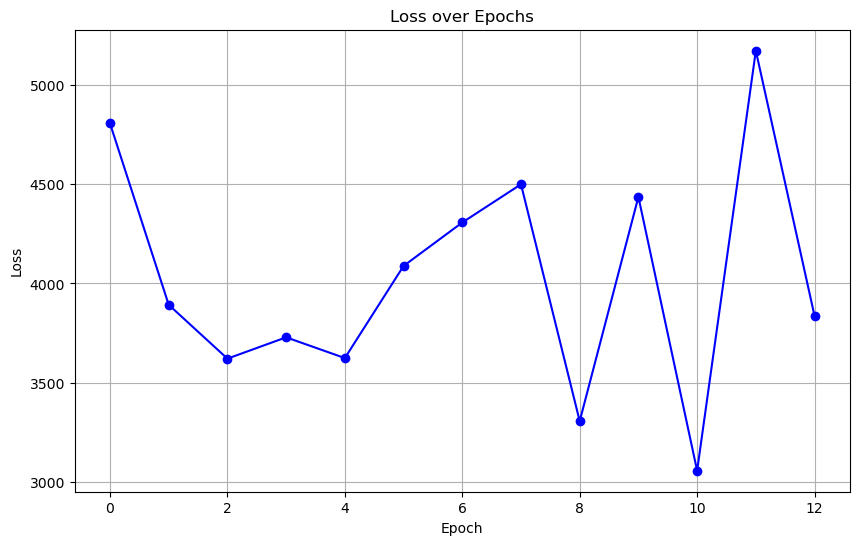

In [27]:
#Partial results for 32 batch size and .00002 learning rate
import pandas as pd
import matplotlib.pyplot as plt

# Data extracted from the log
data = [
    {"Epoch": 0, "Loss": 4807.465},
    {"Epoch": 1, "Loss": 3891.992},
    {"Epoch": 2, "Loss": 3620.385},
    {"Epoch": 3, "Loss": 3728.026},
    {"Epoch": 4, "Loss": 3623.284},
    {"Epoch": 5, "Loss": 4088.145},
    {"Epoch": 6, "Loss": 4307.395},
    {"Epoch": 7, "Loss": 4500.164},
    {"Epoch": 8, "Loss": 3305.137},
    {"Epoch": 9, "Loss": 4436.582},
    {"Epoch": 10, "Loss": 3054.886},
    {"Epoch": 11, "Loss": 5174.167},
    {"Epoch": 12, "Loss": 3836.080},
]

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Loss'], marker='o', linestyle='-', color='b')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [28]:
# Function to check for duplicates across columns
def find_column_duplicates(tensor, check_value=None):
    num_columns = tensor.size(1)
    duplicates = {}
    check_value_duplicates = {}
    
    for col in range(num_columns):
        seen = set()
        col_duplicates = set()
        for row in range(tensor.size(0)):
            value = tensor[row, col].item()
            if value in seen:
                col_duplicates.add(value)
            seen.add(value)
        
        if col_duplicates:
            duplicates[col] = col_duplicates
        
        if check_value is not None and check_value in seen:
            check_value_duplicates[col] = check_value in col_duplicates
    
    return duplicates, check_value_duplicates

In [29]:
duplicates, is_negative_one_duplicate = find_column_duplicates(log._actions, check_value=-1)
print("Duplicate values by column:", duplicates)
print("Is -1 a duplicate in each column:", is_negative_one_duplicate)
    


Duplicate values by column: {1: {-1}}
Is -1 a duplicate in each column: {1: True}


In [30]:
duplicates

{1: {-1}}

In [31]:
print(duplicates)

{1: {-1}}


In [32]:
print(log._actions.shape)

torch.Size([75, 2])


In [33]:
# Sample and plot final states
s0 = one_hot(torch.zeros(10**4).long(), env.state_dim).float()
s = model.sample_states(s0, return_log=False)
# Implement your plot function or use another way to visualize the results
# plot(s, env, matrix_size)

ValueError: Tensor at index 0 is not a sparse tensor.